<a href="https://colab.research.google.com/github/karencfisher/face_express/blob/main/notebooks/vector_randforest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Data is from https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data

The ```icml_face_data.csv``` dataset which contains a total of 34034 samples. It contains 3 columns. The target label is an integer (0, 6), the seven basic emtions:

```
['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
```

The images are stored in the 'pixels' column, as a string of 2304 integer values (0, 255) separated by spaces. These will need be coverted into an array of integer values. Subsequently, they will be needs reshaped into 3-d numpy arrays to be input to the CNN.



In [ ]:
def loadCleanData(fname):
    df = pd.read_csv(fname)
    
    # regularize capitalization and remove leading space in column headings
    fix_cols = {s : s.lower().strip() for s in df.columns.to_list()}
    df.rename(columns = fix_cols, inplace=True)
    
    # convert pixels from strings to lists of integers
    df['pixels'] = df['pixels'].apply(lambda x: [int(i) for i in x.split()])
    
    # Not using the 'usage' column, so can be dropped
    df.drop('usage', axis=1, inplace=True)
    
    return df

In [ ]:
df = loadCleanData('/content/drive/MyDrive/face express data/icml_face_data.csv')
df.head()

,emotion,pixels
0,0,"[70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, 4..."
1,0,"[151, 150, 147, 155, 148, 133, 111, 140, 170, ..."
2,2,"[231, 212, 156, 164, 174, 138, 161, 173, 182, ..."
3,4,"[24, 32, 36, 30, 32, 23, 19, 20, 30, 41, 21, 2..."
4,6,"[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 15, 23..."


In [ ]:
df_labels = pd.read_csv('https://raw.githubusercontent.com/microsoft/FERPlus/master/fer2013new.csv')
df_labels.head()

,Usage,Image name,neutral,happiness,surprise,sadness,anger,disgust,fear,contempt,unknown,NF
0,Training,fer0000000.png,4,0,0,1,3,2,0,0,0,0
1,Training,fer0000001.png,6,0,1,1,0,0,0,0,2,0
2,Training,fer0000002.png,5,0,0,3,1,0,0,0,1,0
3,Training,fer0000003.png,4,0,0,4,1,0,0,0,1,0
4,Training,fer0000004.png,9,0,0,1,0,0,0,0,0,0


In [ ]:
df_labels = df_labels[['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear', 'contempt', 'unknown', 'NF']]
fer2013_new = pd.concat([df, df_labels], axis=1)
fer2013_new = fer2013_new[fer2013_new['NF'] < 10]

fer2013_new.head()

,emotion,pixels,neutral,happiness,surprise,sadness,anger,disgust,fear,contempt,unknown,NF
0,0,"[70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, 4...",4,0,0,1,3,2,0,0,0,0
1,0,"[151, 150, 147, 155, 148, 133, 111, 140, 170, ...",6,0,1,1,0,0,0,0,2,0
2,2,"[231, 212, 156, 164, 174, 138, 161, 173, 182, ...",5,0,0,3,1,0,0,0,1,0
3,4,"[24, 32, 36, 30, 32, 23, 19, 20, 30, 41, 21, 2...",4,0,0,4,1,0,0,0,1,0
4,6,"[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 15, 23...",9,0,0,1,0,0,0,0,0,0


In [ ]:
# Select all but NF for use
y = fer2013_new[['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear', 'contempt']].values

# Majority rule
def makeClasses(votes):
  probs = []
  for row in range(votes.shape[0]):
    # put any contempt votes to disgust
    votes[row][5] += votes[row][7]
    y = np.argmax(votes[row][:7])
    probs.append(y)

  return np.array(probs)

In [ ]:
classes = ['Neutral', 'Happy', 'Surprise', 'Sad', 'Angry', 'Disgust', 'Fear']

In [ ]:
fer2013_new['emotion'] = makeClasses(y)
fer2013_new.head(10)

,emotion,pixels,neutral,happiness,surprise,sadness,anger,disgust,fear,contempt,unknown,NF
0,0,"[70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, 4...",4,0,0,1,3,2,0,0,0,0
1,0,"[151, 150, 147, 155, 148, 133, 111, 140, 170, ...",6,0,1,1,0,0,0,0,2,0
2,0,"[231, 212, 156, 164, 174, 138, 161, 173, 182, ...",5,0,0,3,1,0,0,0,1,0
3,0,"[24, 32, 36, 30, 32, 23, 19, 20, 30, 41, 21, 2...",4,0,0,4,1,0,0,0,1,0
4,0,"[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 15, 23...",9,0,0,1,0,0,0,0,0,0
5,0,"[55, 55, 55, 55, 55, 54, 60, 68, 54, 85, 151, ...",6,0,0,1,0,0,1,1,1,0
6,3,"[20, 17, 19, 21, 25, 38, 42, 42, 46, 54, 56, 6...",2,0,0,8,0,0,0,0,0,0
7,1,"[77, 78, 79, 79, 78, 75, 60, 55, 47, 48, 58, 7...",0,10,0,0,0,0,0,0,0,0
8,1,"[85, 84, 90, 121, 101, 102, 133, 153, 153, 169...",0,10,0,0,0,0,0,0,0,0
9,2,"[255, 254, 255, 254, 254, 179, 122, 107, 95, 1...",0,0,6,0,0,0,4,0,0,0


In [ ]:
import dlib
from imutils import face_utils, resize

!wget https://github.com/italojs/facial-landmarks-recognition/blob/master/shape_predictor_68_face_landmarks.dat?raw=true

--2020-11-24 10:56:19--  https://github.com/italojs/facial-landmarks-recognition/blob/master/shape_predictor_68_face_landmarks.dat?raw=true
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/italojs/facial-landmarks-recognition/raw/master/shape_predictor_68_face_landmarks.dat [following]
--2020-11-24 10:56:20--  https://github.com/italojs/facial-landmarks-recognition/raw/master/shape_predictor_68_face_landmarks.dat
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/italojs/facial-landmarks-recognition/master/shape_predictor_68_face_landmarks.dat [following]
--2020-11-24 10:56:20--  https://raw.githubusercontent.com/italojs/facial-landmarks-recognition/master/shape_predictor_68_face_landmarks.dat
Resolving raw.githubusercontent.com (raw.githubuserconten

In [ ]:
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat?raw=true")

def align(img, reshape=True):
  if reshape:
    image = np.array(img, dtype=np.uint8).reshape(48, 48)
  else:
    image = img
  fa = face_utils.FaceAligner(predictor, desiredLeftEye=(.23, .23), desiredFaceWidth=48)
  rect = dlib.rectangle(0, 0, 48, 48)
  aligned_img = fa.align(image, image, rect)
  return aligned_img


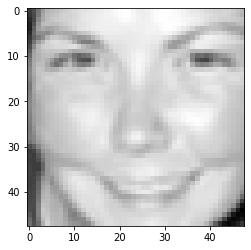

In [ ]:
img = align(df.iloc[8]['pixels'])
plt.imshow(img, cmap='gray')

In [ ]:
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat?raw=true")

def vectorizeFace(image, reshape=True):
  img = align(image, reshape)
  rect = dlib.rectangle(0, 0, 48, 48)
  shapes = predictor(img, rect)
  vect = list(face_utils.shape_to_np(shapes).reshape(136))
  return vect

In [ ]:
fer2013_new['vector'] = fer2013_new['pixels'].apply(vectorizeFace)
fer2013_new.head()

,emotion,pixels,neutral,happiness,surprise,sadness,anger,disgust,fear,contempt,unknown,NF,vector
0,0,"[70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, 4...",4,0,0,1,3,2,0,0,0,0,"[-5, 12, -4, 20, -3, 27, -1, 34, 1, 40, 7, 44,..."
1,0,"[151, 150, 147, 155, 148, 133, 111, 140, 170, ...",6,0,1,1,0,0,0,0,2,0,"[-1, 18, 0, 24, 1, 30, 3, 35, 5, 40, 8, 45, 13..."
2,0,"[231, 212, 156, 164, 174, 138, 161, 173, 182, ...",5,0,0,3,1,0,0,0,1,0,"[0, 9, 0, 16, 2, 22, 3, 29, 4, 36, 7, 42, 12, ..."
3,0,"[24, 32, 36, 30, 32, 23, 19, 20, 30, 41, 21, 2...",4,0,0,4,1,0,0,0,1,0,"[4, 10, 4, 16, 5, 21, 5, 27, 6, 33, 9, 38, 12,..."
4,0,"[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 15, 23...",9,0,0,1,0,0,0,0,0,0,"[-3, 14, -2, 20, -1, 27, 0, 33, 3, 39, 6, 44, ..."


In [ ]:
def visualizeFaceVector(row):
  vector = fer2013_new.iloc[row]['vector']
  vec = np.array(vector).reshape(len(vector) // 2, 2)
  x = [vec[i][0] for i in range(vec.shape[0])]
  y = [vec[i][1] for i in range(vec.shape[0])]
  img = align(fer2013_new.iloc[row]['pixels'])
  plt.figure(figsize=(5,5))
  plt.imshow(img, cmap='gray')
  plt.scatter(x, y, color='red')
  plt.title(classes[fer2013_new.iloc[row]['emotion']])
  plt.show()

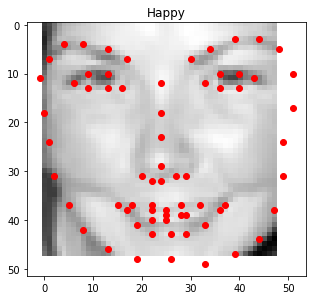

In [ ]:
visualizeFaceVector(8)

In [ ]:
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix

import seaborn as sns

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(fer2013_new['vector'],
                                                    fer2013_new['emotion'],
                                                    test_size=0.2,
                                                    stratify=fer2013_new['emotion'],
                                                    random_state=42)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((28568,), (7143,), (28568,), (7143,))

In [ ]:
# transform lists of vector values into numpy arrays
x_train = np.vstack(x_train)
x_test = np.vstack(x_test)

# Convert the pandas series of target classes to numpy array
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

x_train.shape, y_train.shape

((28568, 136), (28568,))

In [ ]:
clf = RandomForestClassifier(random_state=42)
clf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
score = clf.score(x_test, y_test)
print(f'Test accuracy = {round(score * 100, 2)} %')

Test accuracy = 62.05 %


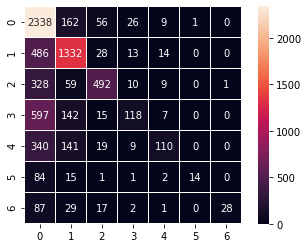

In [ ]:
y_pred = clf.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', linewidths=.2, square=True);


In [ ]:
classes

['Neutral', 'Happy', 'Surprise', 'Sad', 'Angry', 'Disgust', 'Fear']

In [ ]:
def showSample():
  index = np.random.randint(0, fer2013_new.shape[0])
  vector = np.array(fer2013_new.iloc[index]['vector'])

  preds = clf.predict_proba([vector])
  predict = np.argmax(preds[0])
  prob = float(preds[0][predict])

  print(predict == fer2013_new.iloc[index]['emotion'])
  print(f'Predicted {classes[predict]}')
  print(f'Confidence {round(prob * 100, 2)} %')
  print(f'Actual {classes[fer2013_new.iloc[index]["emotion"]]}')

  vec = np.array(vector).reshape(len(vector) // 2, 2)
  x = [vec[i][0] for i in range(vec.shape[0])]
  y = [vec[i][1] for i in range(vec.shape[0])]
  img = align(fer2013_new.iloc[index]['pixels'])
  plt.figure(figsize=(5,5))
  plt.imshow(img, cmap='gray')
  plt.scatter(x, y, color='red')
  plt.show()

True
Predicted Surprise
Confidence 87.0 %
Actual Surprise


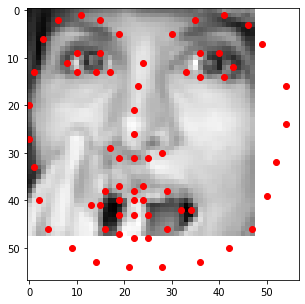

In [ ]:
showSample()

In [ ]:
!wget https://c8.alamy.com/comp/T2MGKP/young-handsome-man-at-home-scared-in-shock-with-a-surprise-face-afraid-and-excited-with-fear-expression-T2MGKP.jpg

--2020-11-24 12:37:01--  https://c8.alamy.com/comp/T2MGKP/young-handsome-man-at-home-scared-in-shock-with-a-surprise-face-afraid-and-excited-with-fear-expression-T2MGKP.jpg
Resolving c8.alamy.com (c8.alamy.com)... 52.52.162.93, 52.9.170.225, 52.8.34.96, ...
Connecting to c8.alamy.com (c8.alamy.com)|52.52.162.93|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘young-handsome-man-at-home-scared-in-shock-with-a-surprise-face-afraid-and-excited-with-fear-expression-T2MGKP.jpg’

young-handsome-man-     [ <=>                ] 114.83K  --.-KB/s    in 0.1s    

Last-modified header invalid -- time-stamp ignored.
2020-11-24 12:37:01 (809 KB/s) - ‘young-handsome-man-at-home-scared-in-shock-with-a-surprise-face-afraid-and-excited-with-fear-expression-T2MGKP.jpg’ saved [117590]



In [ ]:
import cv2

def predictEmotion(image):
  image = cv2.imread(image)
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  rects = detector(gray, 1)

  for rect in rects:
    img = gray[rect.top(): rect.bottom() + 1, rect.left(): rect.right() + 1]
    img = resize(img, width=48)
    print(img.shape)

    vector = vectorizeFace(img, reshape=False)
    probs = clf.predict_proba([vector])
    predict = np.argmax(probs[0])
    prob = probs[0][predict]

    caption = f'{classes[predict]} {str(round(prob * 100))} %'
    (x, y, w, h) = face_utils.rect_to_bb(rect)
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(image, caption,(x - 10, y - 10),
		        cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 0), 2)

  plt.figure(figsize=(8, 12))
  plt.imshow(image)
    


(48, 48)


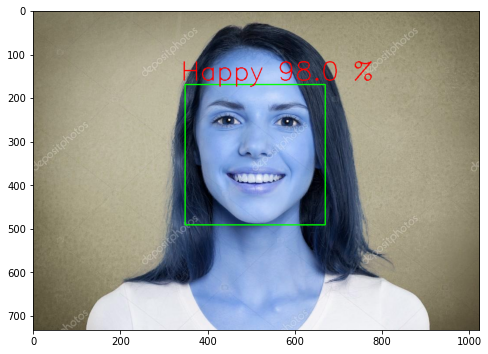

In [ ]:
predictEmotion('happy.jpg')

(47, 48)


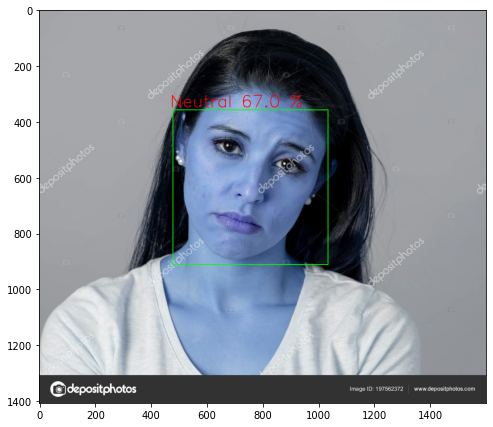

In [ ]:
predictEmotion('woman2.jpg')

(48, 48)


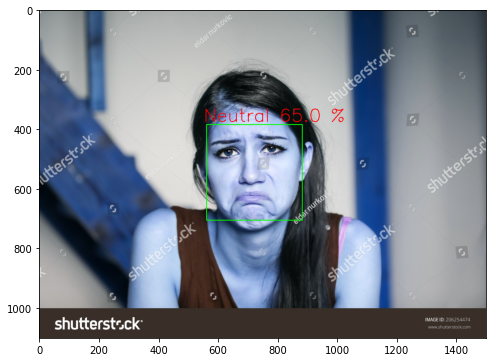

In [ ]:
predictEmotion('woman3.jpg')

(48, 48)


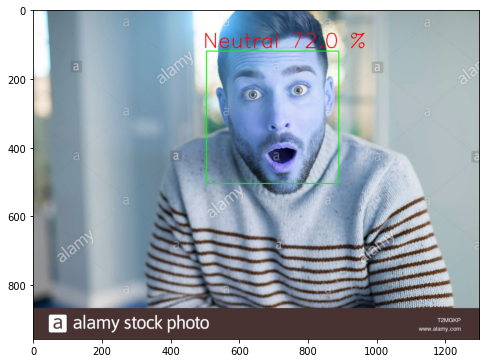

In [ ]:
predictEmotion('surprise2.jpg')